In [ ]:
# Cell 1
# data preprocessing and train-test split

# import necessary libraries for data manipulation, model evaluation, and plotting
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from sklearn.utils import resample

### Define the balance_data function for minority class oversampling

# try class weights first
def balance_data(df):
    values = df['y'].value_counts()
    majority = df[df['y'] == values.idxmax()]
    desired_samples = len(majority)

    for label in values.index:
        if label == values.idxmax():
            continue
        minority = df[df['y'] == label]
        upsampled_minority = resample(minority,
                                      replace=True,  # Sample with replacement
                                      n_samples=desired_samples,  # Match number of majority class
                                      random_state=42)
        majority = pd.concat([majority, upsampled_minority])

    return majority

# load the preprocessed dataset from a CSV file
dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")

# extract text data and specific SDoH categories from the dataset
text_data = dataset["text"].to_list()
sdoh_data = {
    "sdoh_community_present": dataset["sdoh_community_present"].to_list(),
    "sdoh_community_absent": dataset["sdoh_community_absent"].to_list(),
    "sdoh_education": dataset["sdoh_education"].to_list(),
    "sdoh_economics": dataset["sdoh_economics"].to_list(),
    "sdoh_environment": dataset["sdoh_environment"].to_list(),
    "behavior_alcohol": dataset["behavior_alcohol"].to_list(),
    "behavior_tobacco": dataset["behavior_tobacco"].to_list(),
    "behavior_drug": dataset["behavior_drug"].to_list()
}

# prepare directories for storing train-test split data for each SDoH category
base_path = 'test_train_split/behavior_drug'
os.makedirs(base_path, exist_ok=True)

# Iterate through each SDOH data category to split and save as separate CSV files
for category, data in sdoh_data.items():
    base_path = f"test_train_split/{category}"
    os.makedirs(base_path, exist_ok=True)

    # Split data for the current category into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        text_data, data, random_state=0, train_size=0.8, stratify=data
    ) #maybe try a different test size (0.7/0.3)

    #########
     # Convert training set to DataFrame for oversampling
    train_df = pd.DataFrame({
        'text': X_train,
        'y': y_train
    })

     # Apply the oversampling function here
    balanced_train_df = balance_data(train_df)

    # Extract the balanced data
    X_train_balanced = balanced_train_df['text'].tolist()
    y_train_balanced = balanced_train_df['y'].tolist()

    # Save all splits as CSV files
    pd.DataFrame({"text":  X_train_balanced}).to_csv(f"{base_path}/X_train.csv", index=False)
    pd.DataFrame({"text": X_val}).to_csv(f"{base_path}/X_val.csv", index=False)
    pd.DataFrame({category: y_train_balanced}).to_csv(f"{base_path}/y_train.csv", index=False)
    pd.DataFrame({category: y_val}).to_csv(f"{base_path}/y_val.csv", index=False)

when the dataset is imbalanced, models might be biased towards majority class, so oversampling the minority class makes the distribution more balanced. this ensures the model learns features from all classes more effectively. thus, improving recall rate.

In [ ]:
# Cell 2
# model training and evaluation setup

# install required libraries
!pip install transformers[torch] accelerate -U plotting

# import necessary libraries
import datetime
import os
import torch
from torch.optim import AdamW  # variant of Adam with weight decay
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer, TrainingArguments, Trainer
import pandas as pd
import json
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback
from plotting import *
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]

# Initialize tokenizer and model configuration
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(label_columns))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Compute class weights for each category
class_weights_dict = {}
for category in label_columns:
    labels = dataset[category].values
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights_dict[category] = torch.tensor(weights, dtype=torch.float32)

# Compute class weights for each label
class_weights = []
for category in label_columns:
    labels = dataset[category].values
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights.append(torch.tensor(weights, dtype=torch.float).to(device))

def save_metrics_to_csv(json_filepath, csv_filename):
    with open(json_filepath) as file:
        data = json.load(file)

        log_history = data['log_history'] #focus on this column for history
        df = pd.DataFrame(log_history) # Convert the list of dictionaries to a DataFrame

        df.to_csv(csv_filename, index=False)

def plot_metric_from_tensor(log_dir, output_dir, steps_per_epoch):

 # Calculate steps_per_epoch based on training data and training arguments
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    graph1_data = event_acc.Scalars("eval/loss")
    graph2_data = event_acc.Scalars("train/loss")

    # convert steps to epochs
    epochs1 = [event.step / steps_per_epoch for event in graph1_data]
    values1 = [event.value for event in graph1_data]

    epochs2 = [event.step / steps_per_epoch for event in graph2_data]
    values2 = [event.value for event in graph2_data]

    plt.figure(figsize=(10, 6))

    plt.plot(epochs1, values1, label="Validation Loss")
    plt.plot(epochs2, values2, label="Train Loss")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Overlap")

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the graph to the specified folder
    plt.savefig(os.path.join(output_dir, 'metrics_plot.png'))
    plt.show()


def compute_metrics(pred): #evaluation metrics function
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def get_latest_checkpoint(folder_path):
    # Get a list of all files and directories in the specified folder
    files_and_dirs = os.listdir(folder_path)

    # Filter only directories (assumed to be checkpoints)
    checkpoint_dirs = [d for d in files_and_dirs if os.path.isdir(os.path.join(folder_path, d))]

    if not checkpoint_dirs:
        print("No checkpoint directories found.")
        return None

    # Extract the checkpoint numbers from the directory names
    checkpoint_numbers = [int(d.split('-')[1]) for d in checkpoint_dirs]

    # Identify the directory with the highest checkpoint number
    latest_checkpoint = os.path.join(folder_path, f"checkpoint-{max(checkpoint_numbers)}")

    return latest_checkpoint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 30.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.527600,0.227545,0.907473,0.905990,0.908735,0.907473


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.527600,0.227545,0.907473,0.905990,0.908735,0.907473
2,0.252600,0.252490,0.934520,0.933730,0.935581,0.934520
3,0.147000,0.219429,0.943060,0.942963,0.942932,0.943060
4,0.078700,0.244801,0.943060,0.942782,0.943007,0.943060


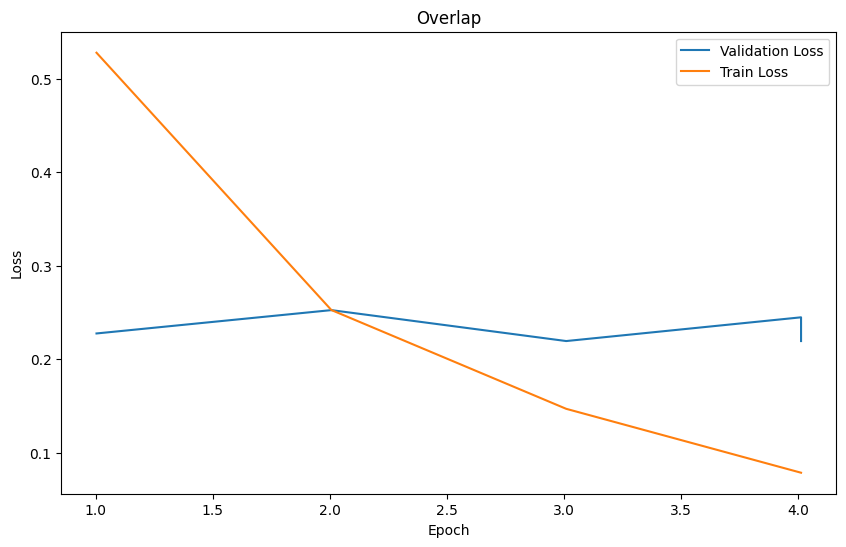

Evaluation Results: {'eval_loss': 0.2194293737411499, 'eval_accuracy': 0.9430604982206405, 'eval_f1': 0.942963282364672, 'eval_precision': 0.9429318494335222, 'eval_recall': 0.9430604982206405, 'eval_runtime': 8.0004, 'eval_samples_per_second': 175.616, 'eval_steps_per_second': 2.75, 'epoch': 4.0}


In [ ]:
# Cell 3
# model training and saving

# install required libraries
!pip install transformers[torch] accelerate -U plotting

# import necessary libraries
import datetime
import os
import torch
from torch.optim import AdamW  # variant of Adam with weight decay
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer, TrainingArguments, Trainer
import pandas as pd
import json
import sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from transformers import EarlyStoppingCallback

from plotting import *

# Define label_columns here
# either turn all into binary(try this first as 0 or 1) or train different models
label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]

# Initialize tokenizer, this is standard approach with GPT-2
num_labels = len(label_columns)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", num_labels = num_labels)
# GPT-2 uses the same token for end-of-sentence and padding.
tokenizer.pad_token = tokenizer.eos_token  # Set pad token

# Ensure the model is compatible with the tokenizer settings
configuration = GPT2ForSequenceClassification.config_class.from_pretrained("gpt2", num_labels= num_labels)
configuration.pad_token_id = tokenizer.pad_token_id
model = GPT2ForSequenceClassification(configuration)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up no decay for certain model parameters to avoid regularization on them
no_decay = ['bias', 'LayerNorm.weight']  # weight decay with a minor penalty during
optimizer_grouped_parameters = [  # no selects params added
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

# load dataset, preprocess, and prepare DataLoader for training and validation
dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")
text_data = dataset["text"].to_list()
sdoh_data = dataset["sdoh_community_present"].to_list() # need to load 8 instead of just community_present that's why the loss doesn't make sense

# can either do binary and multilevel classification or one model per label
# one sdoh per model, don't need to convert to binary because every model will be different

timestamp_fortrain = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size=0.8,
                                                  stratify=sdoh_data) #make it test = 0.3
max_seq_length = 100  # actually 50 but increase to accomadate outliers

# Calculate the number of trainable parameters in the model
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_MB = num_trainable_params * 4 / (1024 ** 2)
effective_batch = 8 / (50*4*model_size_MB) #gpu/seqlength * 4 * model size

# define training arguments and start training with the Trainer
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')


# custom Dataset class for loading training and validation data
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Converting to tensor , maybe use just 'labels'

    def __getitem__(self, idx):
        try:
            item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
            item['labels'] = self.labels[idx].clone().detach()  # Already a tensor, just clone and detach
            return item
        except Exception as e:
            print(f"index error: {idx}: {e}")
            return None

    def __len__(self):
        return len(self.labels) # detach from tensor device

# Initialize the DataLoader for training and validation sets with the tokenized encodings
train_dataset: DataLoader = DataLoader(
    train_encodings,  # These should be the output from the tokenizer
    y_train  # These should be labels, as a list or tensor
)

val_dataset = DataLoader(
    val_encodings,  # These should be the output from the tokenizer
    y_val  # These should be labels, as a list or tensor
)

tensor_logs = f'./logs/tensor_logs/{timestamp_fortrain}' #create seperate logs for tensor/epoch
os.makedirs(tensor_logs, exist_ok=True)
epoch_logs = f'./logs/epoch_logs/{timestamp_fortrain}'
os.makedirs(epoch_logs, exist_ok=True)

# training args - need to adjust
training_args = TrainingArguments(
    output_dir= epoch_logs,  # change to epoch log directory, convert to a text
    logging_strategy='epoch',  # characterize as epoch
    num_train_epochs=4,
    #per_device_train_batch_size=64,  # cpu constraint,  64 approp
    per_device_train_batch_size=16, #reduced batch sie
    per_device_eval_batch_size=64,  # gradient accum if batch size of two, 64 approp
    save_strategy= 'epoch',
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir= tensor_logs,  # change to tensor logs
    #eval_steps=100,
    evaluation_strategy="epoch",
    #accumulate gradients over 4 steps
    #gradient_accumulation_steps = 4
    load_best_model_at_end=True,  # This will load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use eval_loss to determine the best model
    greater_is_better=False,  # Set to False because a lower loss is better

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # 3 is a balance between giving the model enough chance  to improve and stopping early enough to prevent overfitting and unnecessary computation
)

# train the model
trainer.train()

# evaluate the model
evaluation_results = trainer.evaluate()

#readable results
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
latest_checkpoint = get_latest_checkpoint(epoch_logs) # latest checkpoint update to csv
json_path = os.path.join(latest_checkpoint, 'trainer_state.json')
save_metrics_to_csv(json_path, 'eval_metric.csv') #update metrics
plot_metric_from_tensor(tensor_logs, 'graphs', steps_per_epoch)

save_directory = "saved_models/gpt2"

os.makedirs(save_directory, exist_ok=True)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Evaluation Results:", evaluation_results)

save at epoch, and evaluate at epochs load only the best checkpoint during the testing by looking at the training and validation

In [ ]:
# Cell 4
# Evaluation on Test Data

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# function to evaluate the trained model on test data
def evaluate_on_test_data(model_path, test_data_path, tokenizer_path, label_columns, max_seq_length=512):
    # Load the tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    model = GPT2ForSequenceClassification.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load the test data
    test_dataset = pd.read_csv(test_data_path)
    texts = test_dataset["TEXT"].tolist()

    # collect true labels and predictions for each label
    true_labels = {label: test_dataset[label].tolist() for label in label_columns}

    # Tokenize the test data
    test_encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

    # Custom Dataset for test data
    class TestDataset(Dataset):
        def __init__(self, encodings):
            self.encodings = encodings

        def __getitem__(self, idx):
            #return {key: val[idx] for key, val in self.encodings.items()}
              return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        def __len__(self):
            return len(self.encodings.input_ids)

    # prepare DataLoader for test data
    test_dataset = TestDataset(test_encodings)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


    # Prepare to collect predictions
    predictions = {label: [] for label in label_columns}
    results = []

    model.eval()
    with torch.no_grad():
      for batch in test_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        sigmoid_logits = torch.sigmoid(logits).cpu().numpy()  # Apply sigmoid function for binary classification on logits
        threshold = 0.5
        binary_predictions = (sigmoid_logits > threshold).astype(int)  # Apply threshold to get binary predictions
        # Collect binary_predictions for the labels
        for i, label in enumerate(label_columns):
            predictions[label].extend(binary_predictions[:, i])

    # calculate and print the metrics for each label
    for label in label_columns:
        accuracy = accuracy_score(true_labels[label], predictions[label])
        precision = precision_score(true_labels[label], predictions[label], average='weighted')
        recall = recall_score(true_labels[label], predictions[label], average='weighted')
        f1 = f1_score(true_labels[label], predictions[label], average='weighted')
        report = classification_report(true_labels[label], predictions[label], zero_division=0)

          # Append the results for the current label to the list
        results.append({
          'Label': label,
          'Accuracy': accuracy,
          'Precision': precision,
          'Recall': recall,
          'F1 Score': f1
        })

        # Print the results for the current label
        print("Evaluation results saved to /content/model_evaluation_results.csv")
        print(f"Metrics for {label}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Classification Report:")
        print(report)
        print("\n")

        # Convert the list of results to a DataFrame
        results_df = pd.DataFrame(results)

        # Save the DataFrame to a CSV file
        results_df.to_csv('/content/model_evaluation_results.csv', index=False)
        print("Evaluation results saved to /content/model_evaluation_results.csv")
        print("Test evaluation completed for all labels.")

# Paths to the model, tokenizer, and test data
model_path = "saved_models/gpt2"
tokenizer_path = "saved_models/gpt2"
test_data_path = "/content/ANNOTATEDNOTES.csv"

# List of label columns in your test data for evaluation
label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]

# Call the function to evaluate on test data
evaluate_on_test_data(model_path, test_data_path, tokenizer_path, label_columns, max_seq_length=512)


<ipython-input-4-5be8d1862e45>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMet

Evaluation results saved to /content/model_evaluation_results.csv
Metrics for sdoh_community_present:
Accuracy: 0.6320
Precision: 0.3994
Recall: 0.6320
F1 Score: 0.4895
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1950
           1       0.63      1.00      0.77      3349

    accuracy                           0.63      5299
   macro avg       0.32      0.50      0.39      5299
weighted avg       0.40      0.63      0.49      5299



Evaluation results saved to /content/model_evaluation_results.csv
Test evaluation completed for all labels.
Evaluation results saved to /content/model_evaluation_results.csv
Metrics for sdoh_community_absent:
Accuracy: 0.1096
Precision: 0.0120
Recall: 0.1096
F1 Score: 0.0217
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4718
           1       0.11      1.00      0.20       581

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
